In [1]:
import numpy as np
import pandas as pd

import pickle

import scipy
import scipy.sparse as sp

import scripts.training.Dataset_split as spl

from datetime import datetime

In [2]:
PROJECT_FOLDER = "../.."
INPUT_DATA_FOLDER = "data/final_data"
MODEL_FOLDER = "model"
FINAL_TRAIN_MATRIX = "final_train_matrix_v1.pkl"
FINAL_DATETIMES = "final_datetimes_v1"
FINAL_Y = "final_y_v1"
TUNING_FOLDER = f"{MODEL_FOLDER}/tuning"

In [3]:
X = pickle.load(open(f"{PROJECT_FOLDER}/{INPUT_DATA_FOLDER}/{FINAL_TRAIN_MATRIX}", "rb"))
X

<191715x9026 sparse matrix of type '<class 'numpy.float64'>'
	with 129877897 stored elements in Compressed Sparse Row format>

In [4]:
y = pickle.load(open(f"{PROJECT_FOLDER}/{INPUT_DATA_FOLDER}/{FINAL_Y}.pkl", "rb"))
y

0         0
167500    0
159608    0
151693    0
143371    0
         ..
135512    0
119083    0
51952     0
16353     0
191714    0
Name: is_alarm, Length: 191715, dtype: int64

In [5]:
df_dt = pickle.load(open(f"{PROJECT_FOLDER}/{INPUT_DATA_FOLDER}/{FINAL_DATETIMES}.pkl", "rb"))
df_dt

,datetime
0,2022-02-26 00:00:00
167500,2022-02-26 00:00:00
159608,2022-02-26 00:00:00
151693,2022-02-26 00:00:00
143371,2022-02-26 00:00:00
...,...
135512,2023-01-20 23:00:00
119083,2023-01-20 23:00:00
51952,2023-01-20 23:00:00
16353,2023-01-20 23:00:00


In [ ]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import scripts.training.Dataset_split as spl
import os

In [26]:
TUNING_PATH = f"{PROJECT_FOLDER}/{TUNING_FOLDER}/logistic_regression_balanced"
MODEL_NAME = "logistic_regression_v2"
RANDOM_STATE = 1

In [17]:
models = []
model_names = []
true_positive = []
false_positive = []
false_negative = []
true_negative = []

In [9]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(y)):
        if y[i] == 1 and y_pred[i] == 1:
            tp += 1
        elif y[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y[i] == 1 and y_pred[i] == 0:
            fn += 1
        elif y[i] == 0 and y_pred[i] == 0:
            tn += 1
    true_positive.append(tp)
    false_positive.append(fp)
    false_negative.append(fn)
    true_negative.append(tn)
    return tp, fp, fn, tn;

In [ ]:
def display_confusion_graph():
    fig, ax = plt.subplots()
    ax.barh(model_names, true_positive, label='True Positives', color='green')
    ax.barh(model_names, false_positive, left=true_positive, label='False Positives', color='red')
    ax.barh(model_names, false_negative, left=np.array(true_positive) + np.array(false_positive), label='False Negatives', color='orange')
    ax.barh(model_names, true_negative, left=np.array(true_positive) + np.array(false_positive) + np.array(false_negative), label='True Negatives', color='blue')

    # set axis labels and title
    ax.set_xlabel('Confusion values')
    ax.set_ylabel('Models')
    ax.set_title('Models Performance')

    # add legend
    ax.legend()

    # display plot
    plt.show()

In [32]:
def logistic_regression_custom_cv(X, y, n_splits=4, min_split=1, max_split=None, description="default", **kwargs):
    if max_split is None:
        max_split = n_splits
    split = 1
    tss = TimeSeriesSplit(n_splits=n_splits)
    MIN_ITERATION = min_split
    MAX_ITERATION = max_split

    model=LogisticRegression(**kwargs)

    #getting indexes for df_all_features from splitting df_datetime
    print(f"START AT: {datetime.now()}")
    for train_index, test_index in zip(*spl.split_dataset(df_dt, tss)):
        if(split<MIN_ITERATION):
            split+=1
            continue
        if(split>MAX_ITERATION):
            break

        print(f"Split {split}: {datetime.now()}")

        X_train=X[train_index]
        X_test=X[test_index]
        y_train=y[train_index]
        y_test=y[test_index]

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)

        full_name = f"{MODEL_NAME}_{model.solver}_split_{split}_of_{n_splits}_{description}"

        print(f"{full_name}: {score}")
        FOLDER=f"{TUNING_PATH}/{MODEL_NAME}"
        if not os.path.exists(FOLDER):
            os.makedirs(FOLDER)


        models.append(model)
        model_names.append(full_name)
        evaluate_model(model, X, y)

        with open(f"{TUNING_PATH}/{MODEL_NAME}/{full_name}.pkl", 'wb') as handle: pickle.dump(model, handle)
        file = open(f"{TUNING_PATH}/{MODEL_NAME}/{full_name}.txt", 'w');
        file.write(f"{datetime.now()}\n{model.get_params()}")
        file.close
        display_confusion_graph()
        split+=1
    print(f"FINISH: {datetime.now()}")

In [22]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, max_iter=100, random_state=RANDOM_STATE, class_weight="balanced")

START AT: 2023-04-30 13:22:00.383376
Split 1: 2023-04-30 13:22:06.498512


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression_v1_split1/4: 0.5863506808825082
Split 2: 2023-04-30 13:22:17.000771


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression_v1_split2/4: 0.5235749283782698
Split 3: 2023-04-30 13:22:40.104530


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression_v1_split3/4: 0.5330111861601303
Split 4: 2023-04-30 13:23:11.898790


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression_v1_split4/4: 0.5463249172525098
FINISH: 2023-04-30 13:23:51.976692


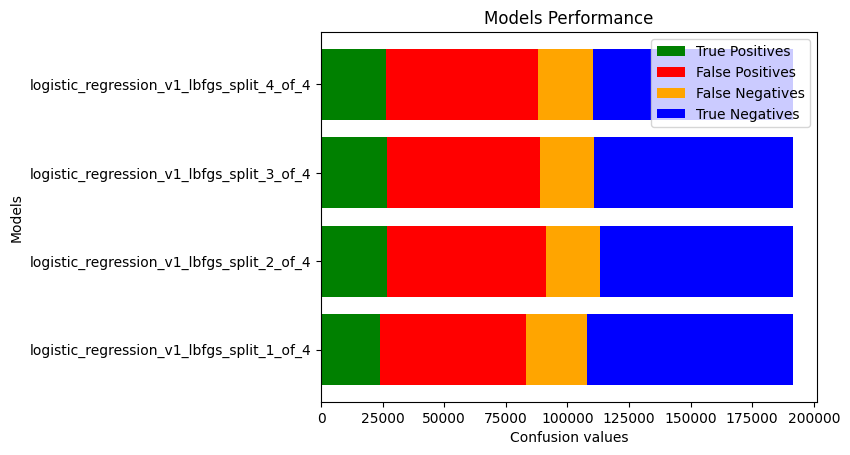

In [25]:
display_confusion_graph()

START AT: 2023-04-30 13:27:46.687838
Split 1: 2023-04-30 13:27:50.928547


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.13887763734906344 <= -0.00012589634996742935 True
  Check Convergence
    1. max |gradient| 1.088694320321818 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.008162074452155665 <= -6.744833648552407e-06 True
  Check Convergence
    1. max |gradient| 0.8513438063313867 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.001293916620538127 <= -1.0874428913243772e-06 True
  Check Convergence
    1. max |gradient| 0.40511380026248295 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished


logistic_regression_v2_split1/4: 0.6874802069038319


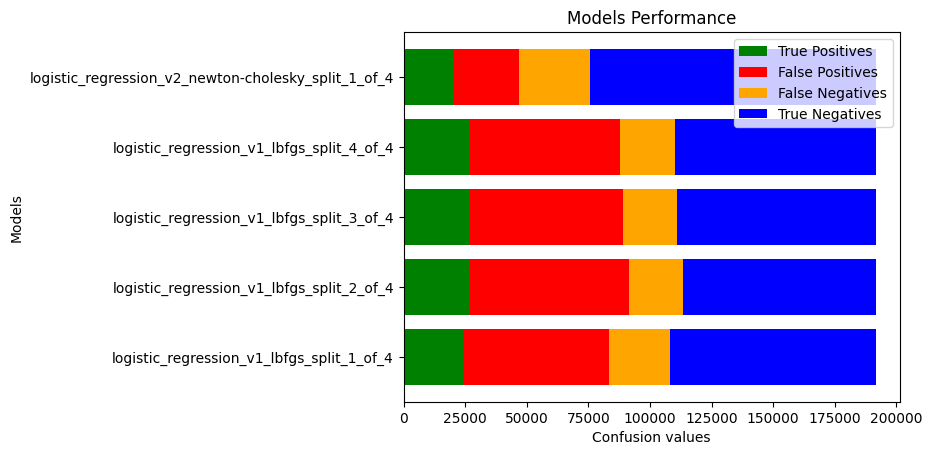

Split 2: 2023-04-30 13:34:48.761257


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.13512684766578043 <= -0.0001225622420691231 True
  Check Convergence
    1. max |gradient| 2.3132349664733702 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.007667265660722178 <= -6.3332371427722315e-06 True
  Check Convergence
    1. max |gradient| 1.1391319783235978 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.001323633470143415 <= -1.0967134313877682e-06 True
  Check Convergence
    1. max |gradient| 0.4429500943717644 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.5min finished


logistic_regression_v2_split2/4: 0.6727890974323275


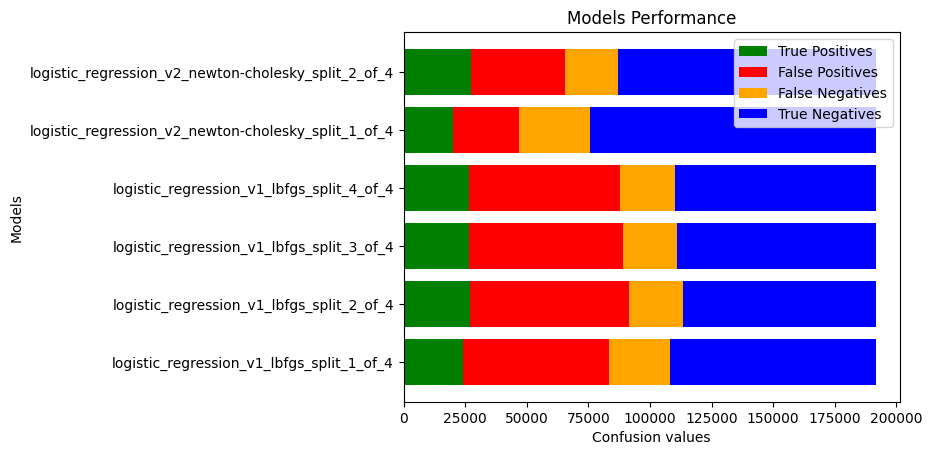

Split 3: 2023-04-30 13:48:20.395032


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.1364551182298156 <= -0.0001242252178115409 True
  Check Convergence
    1. max |gradient| 1.9340419452793296 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.006994308620735135 <= -5.798867503994314e-06 True
  Check Convergence
    1. max |gradient| 1.0039914296797194 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0011861079760052684 <= -9.817562971790783e-07 True
  Check Convergence
    1. max |gradient| 0.3846150550484046 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 17.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 17.2min finished


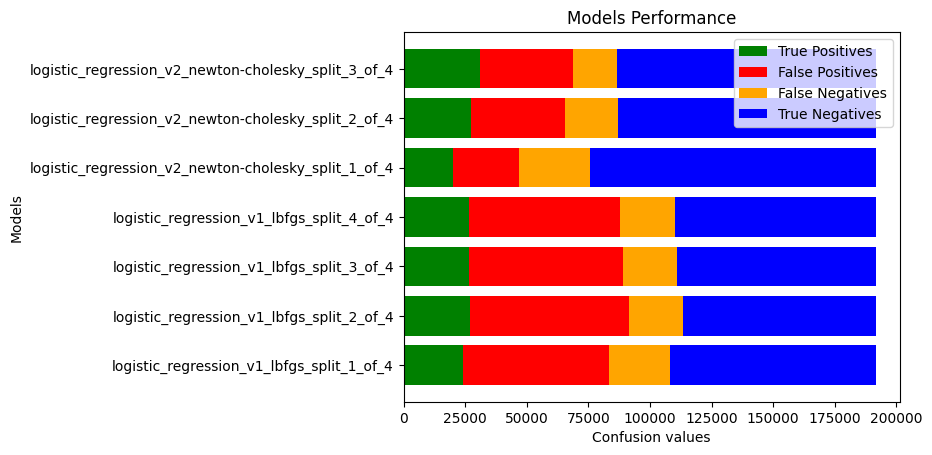

Split 4: 2023-04-30 14:05:37.395691


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.13253739839437007 <= -0.00012092925592966099 True
  Check Convergence
    1. max |gradient| 2.2328464302234 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0063422110770848805 <= -5.275862091572352e-06 True
  Check Convergence
    1. max |gradient| 1.030347135582599 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0010590384118178697 <= -8.742586788841528e-07 True
  Check Convergence
    1. max |gradient| 0.36053538622027426 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min finished


logistic_regression_v2_split4/4: 0.663867385179309


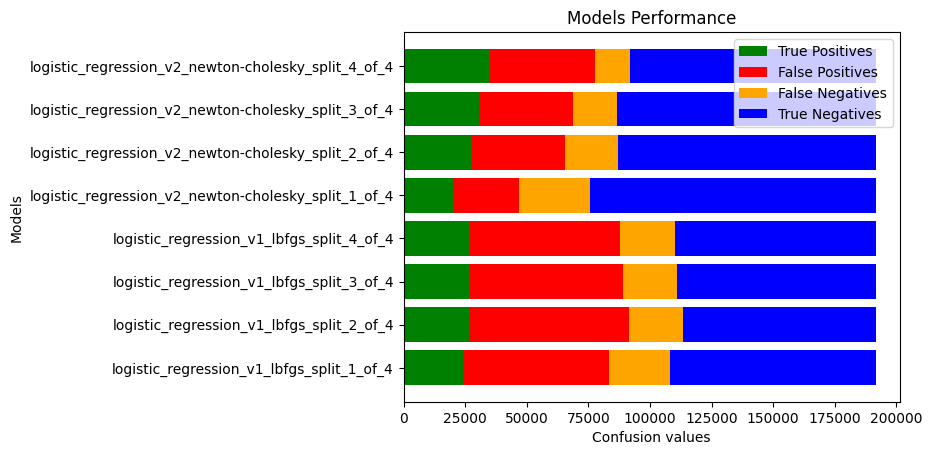

FINISH: 2023-04-30 14:27:31.563769


In [28]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, max_iter=100, random_state=RANDOM_STATE, class_weight="balanced", solver='newton-cholesky', verbose=2)

START AT: 2023-04-30 14:41:09.539229
Split 1: 2023-04-30 14:41:14.275764


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.13887763734906344 <= -0.00012589634996742935 True
  Check Convergence
    1. max |gradient| 1.088694320321818 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.008162074452155665 <= -6.744833648552407e-06 True
  Check Convergence
    1. max |gradient| 0.8513438063313867 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.001293916620538127 <= -1.0874428913243772e-06 True
  Check Convergence
    1. max |gradient| 0.40511380026248295 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min finished


logistic_regression_v2_newton-cholesky_split_1_of_4_warmStart: 0.6874802069038319


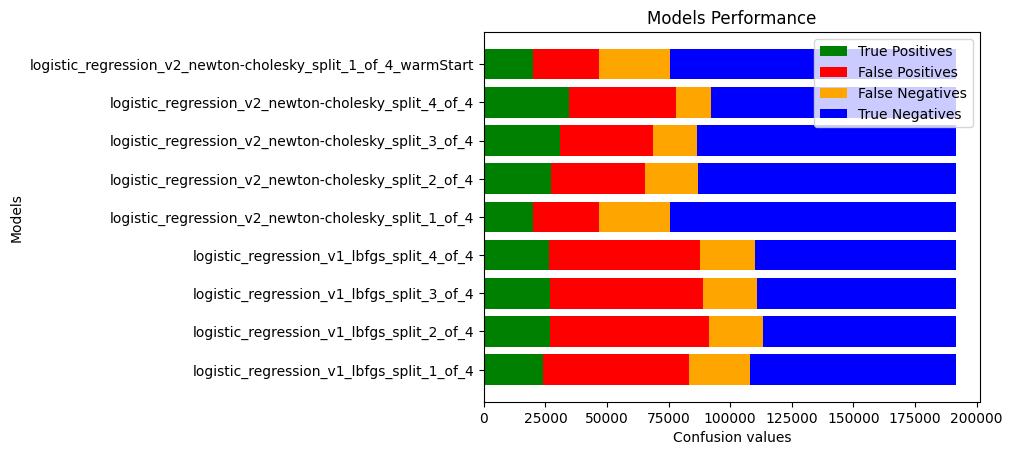

Split 2: 2023-04-30 14:47:39.260037


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.038599607268610114 <= -5.676334827008986e-05 True
  Check Convergence
    1. max |gradient| 10.510941800675987 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: 0.07606456838697562 <= -3.717208580971005e-05 False
      check loss |improvement| <= eps * |loss_old|: 0.07606456838697562 <= 1.9886697485151126e-15 False
    line search iteration=2, step size=0.5
      check loss improvement <= armijo term: 0.018501663257963874 <= -1.8586042904855024e-05 False
      check loss |improvement| <= eps * |loss_old|: 0.018501663257963874 <= 1.9886697485151126e-15 False
    line search iteration=3, step size=0.25
      check loss improvement <= armijo term: -0.0062289635682979405 <= -9.29302145242

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.5min finished


logistic_regression_v2_newton-cholesky_split_2_of_4_warmStart: 0.6727890974323275


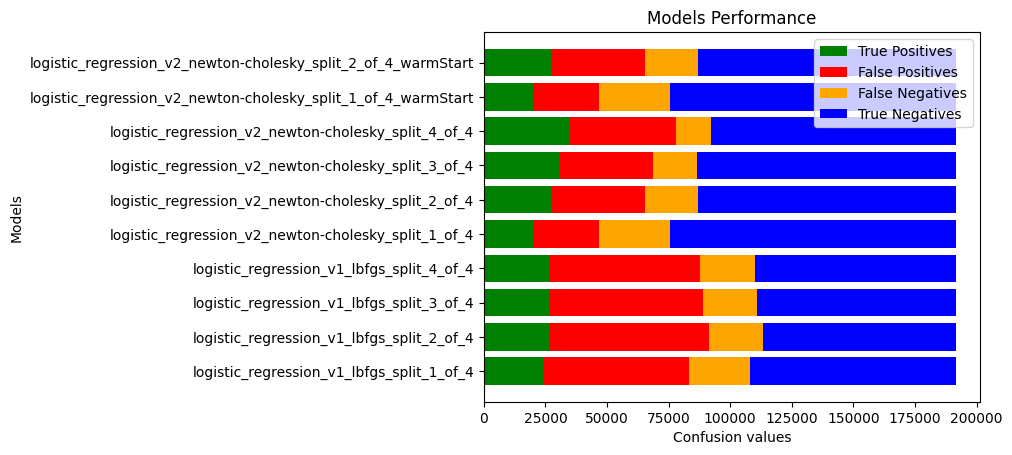

Split 3: 2023-04-30 14:59:14.001318


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0269748491956453 <= -2.9496237507513287e-05 True
  Check Convergence
    1. max |gradient| 3.9223737527442073 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0006481626913098504 <= -2.210831300928241e-06 True
  Check Convergence
    1. max |gradient| 1.0243300082500513 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0010720356788401775 <= -1.3382561927476473e-06 True
  Check Convergence
    1. max |gradient| 0.261978414200251 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.4min finished


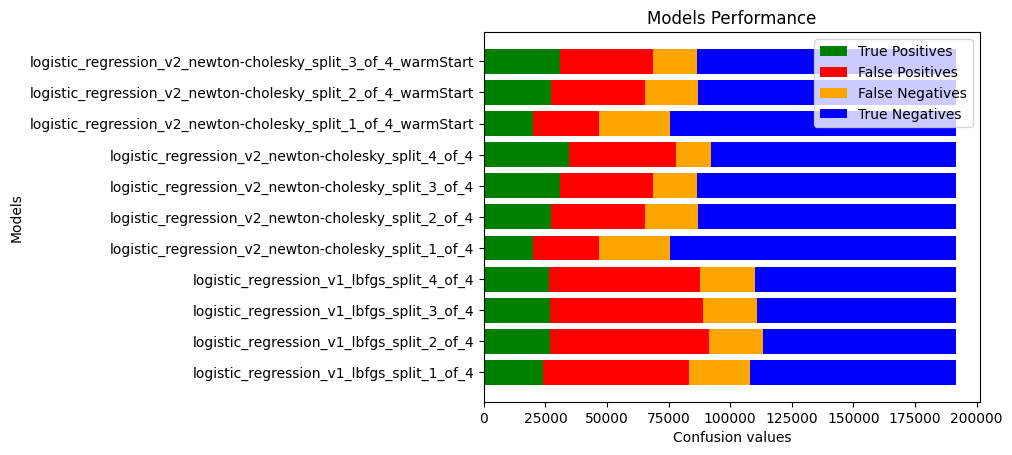

Split 4: 2023-04-30 15:15:42.964043


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.016467594572904032 <= -1.7226535950758445e-05 True
  Check Convergence
    1. max |gradient| 2.350033449166777 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.0004160431209075943 <= -4.1199121701744485e-07 True
  Check Convergence
    1. max |gradient| 0.060960258106362054 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -3.452901490064164e-06 <= -3.3197298706503585e-09 True
  Check Convergence
    1. max |gradient| 0.0005816568412424748 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search i

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.8min finished


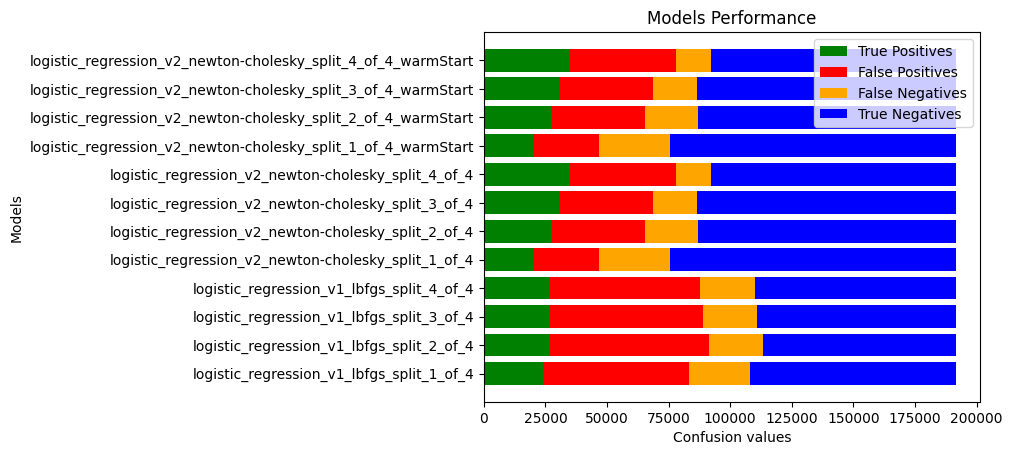

FINISH: 2023-04-30 15:30:34.366790


In [33]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, description="warmStart", max_iter=100, random_state=RANDOM_STATE, class_weight="balanced", solver='newton-cholesky', verbose=2, warm_start=True)


START AT: 2023-04-30 16:58:31.198021
Split 1: 2023-04-30 16:58:35.747860
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_1_of_4_warmStart: 0.6229811041908583


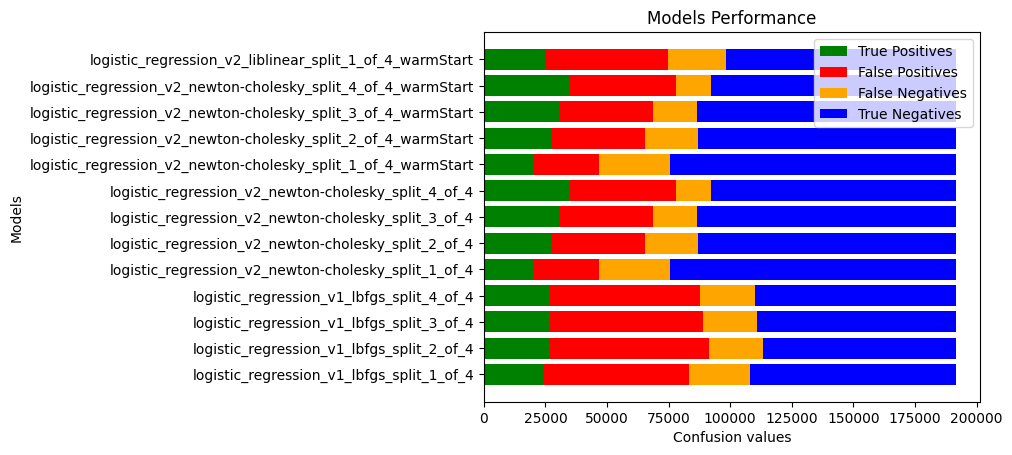

Split 2: 2023-04-30 16:59:51.771347
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_2_of_4_warmStart: 0.5580336822940373


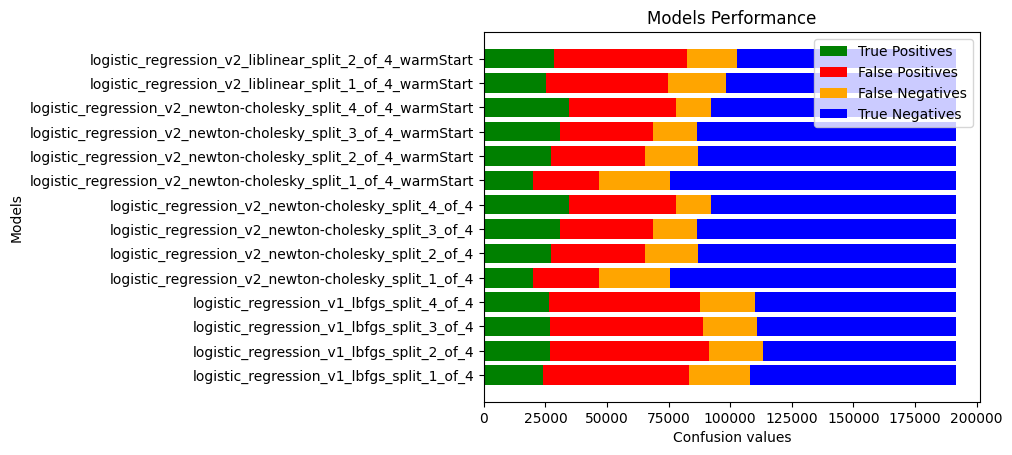

Split 3: 2023-04-30 17:02:36.832147
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_3_of_4_warmStart: 0.6320580932802947


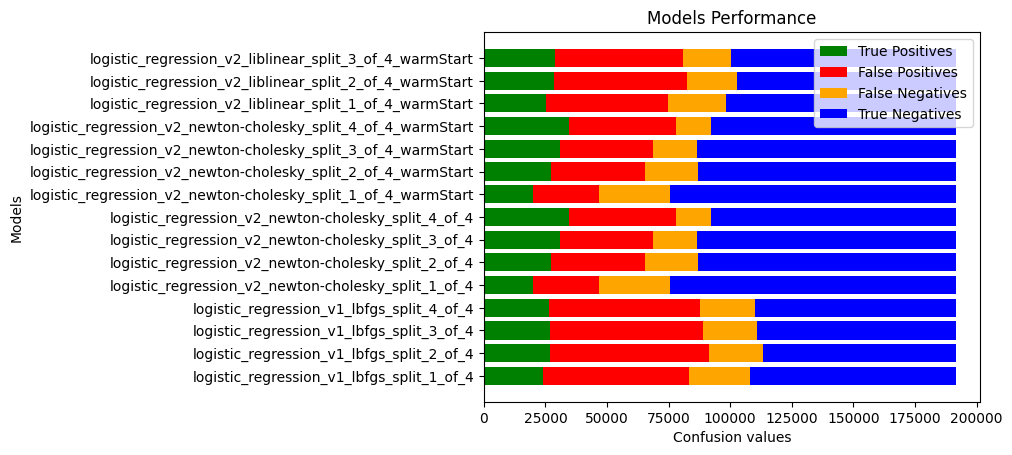

Split 4: 2023-04-30 17:07:15.516663
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_4_of_4_warmStart: 0.5891074212873048


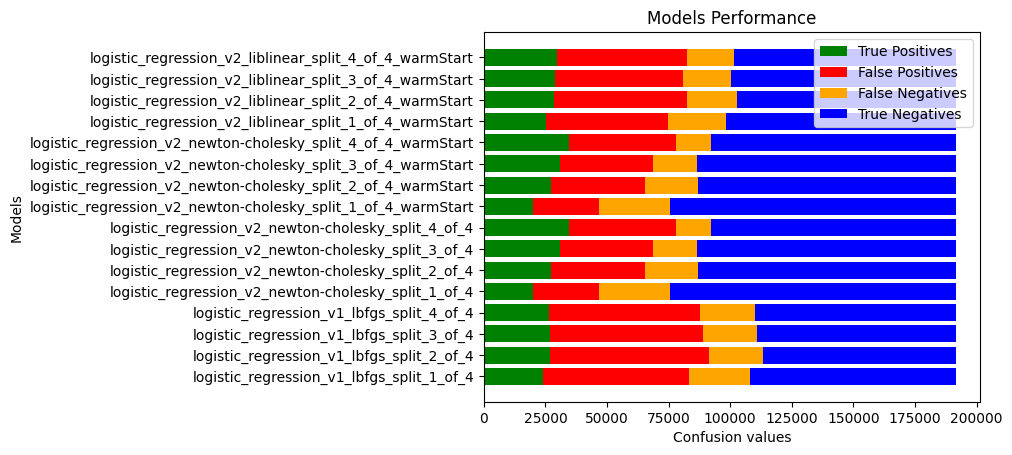

FINISH: 2023-04-30 17:12:46.632212


In [34]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, description="warmStart", max_iter=100, random_state=RANDOM_STATE, class_weight="balanced", solver='liblinear', verbose=2, warm_start=True)


START AT: 2023-04-30 17:14:11.621243
Split 1: 2023-04-30 17:14:16.001557
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_1_of_4_warm_300iter: 0.6384725007917238


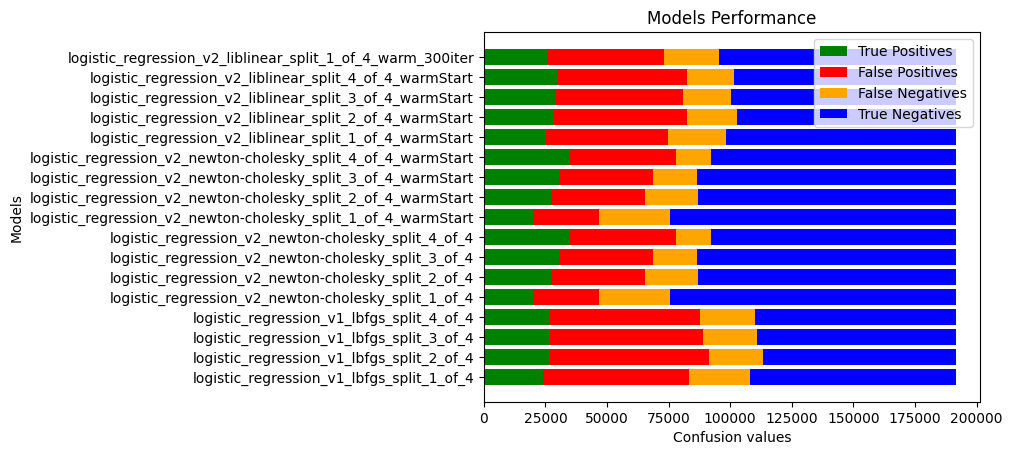

Split 2: 2023-04-30 17:18:47.687618
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_2_of_4_warm_300iter: 0.565798281078476


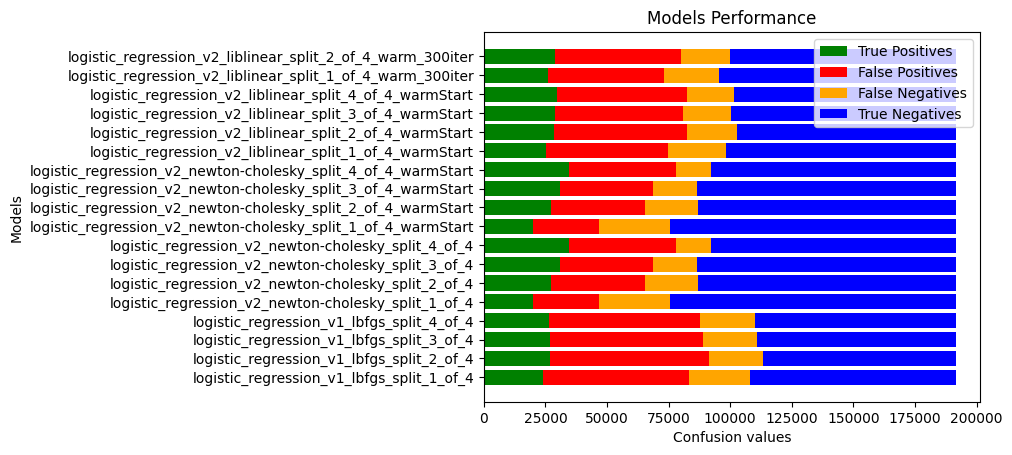

Split 3: 2023-04-30 17:27:30.661696
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_3_of_4_warm_300iter: 0.6620925327709106


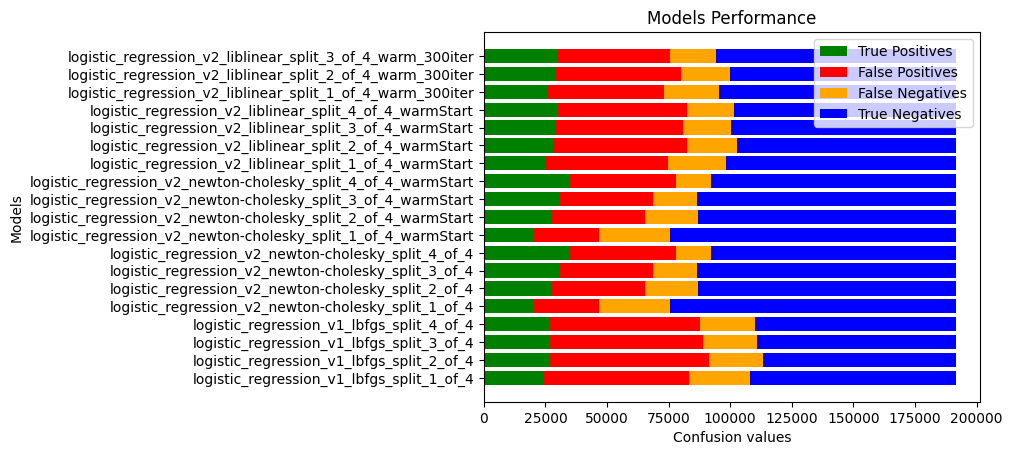

Split 4: 2023-04-30 17:40:40.675483
[LibLinear]

C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


logistic_regression_v2_liblinear_split_4_of_4_warm_300iter: 0.6419563968596985


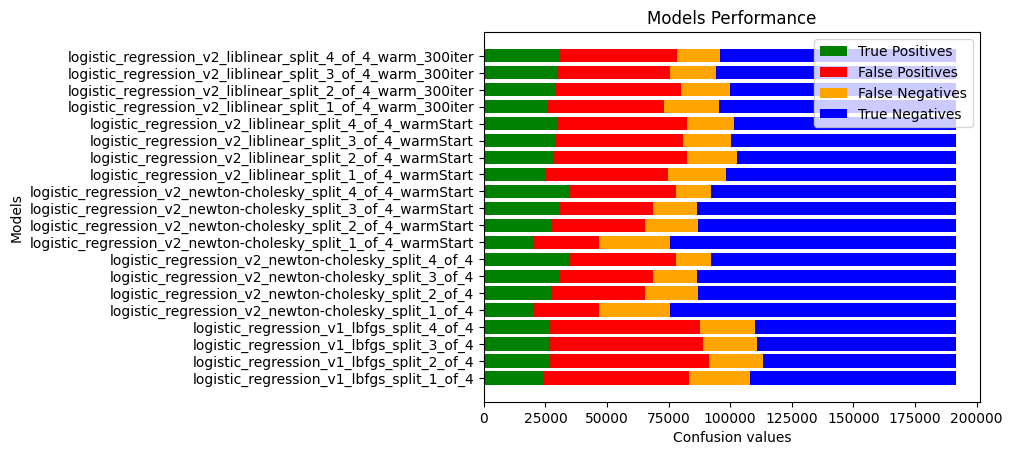

FINISH: 2023-04-30 17:57:20.340158


In [35]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, description="warm_300iter", max_iter=300, random_state=RANDOM_STATE, class_weight="balanced", solver='liblinear', verbose=4, warm_start=True)


START AT: 2023-04-30 18:14:00.620573
Split 4: 2023-04-30 18:14:07.536067
[LibLinear]logistic_regression_v2_liblinear_split_4_of_4_1000iter: 0.6645512487348524


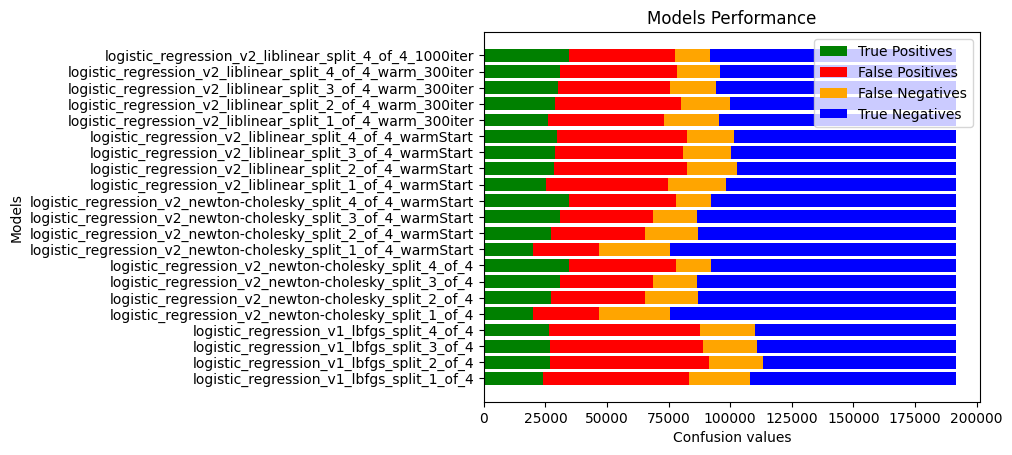

FINISH: 2023-04-30 19:07:51.264204


In [36]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, min_split=4,description="1000iter", max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced", solver='liblinear', verbose=4, warm_start=True)

START AT: 2023-04-30 19:18:54.884771
Split 1: 2023-04-30 19:19:03.229013


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.1min finished


logistic_regression_v2_newton-cg_split_1_of_4_cold_100iter: 0.6875065976987227


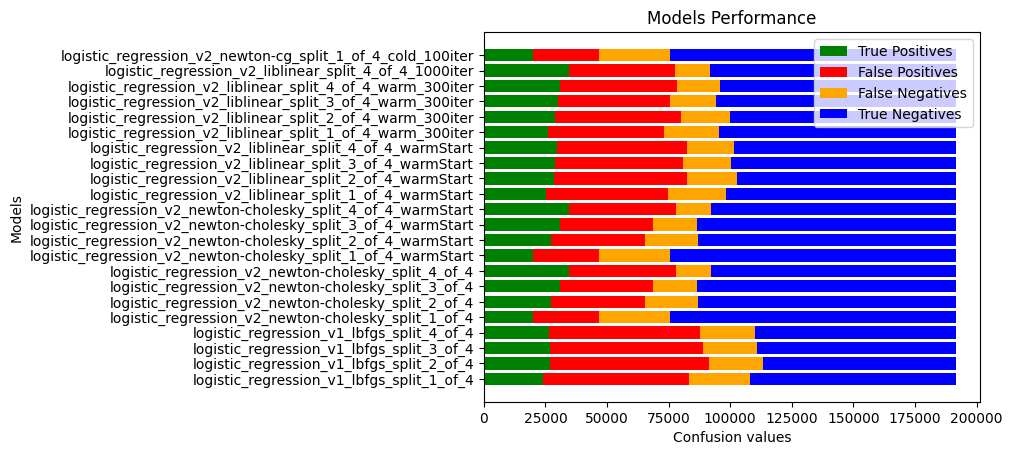

Split 2: 2023-04-30 19:31:13.335642


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.3min finished


logistic_regression_v2_newton-cg_split_2_of_4_cold_100iter: 0.6727623229537605


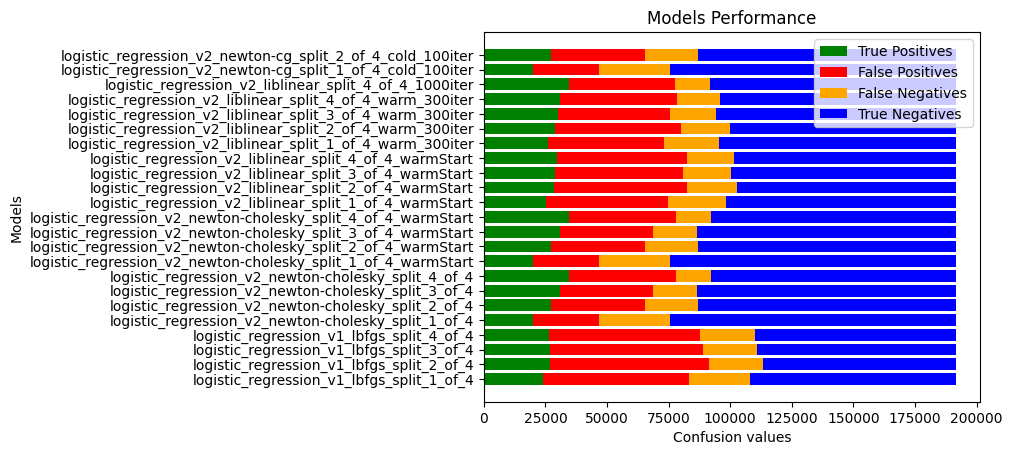

Split 3: 2023-04-30 19:55:33.440659


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 35.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 35.8min finished


logistic_regression_v2_newton-cg_split_3_of_4_cold_100iter: 0.7207464559361401


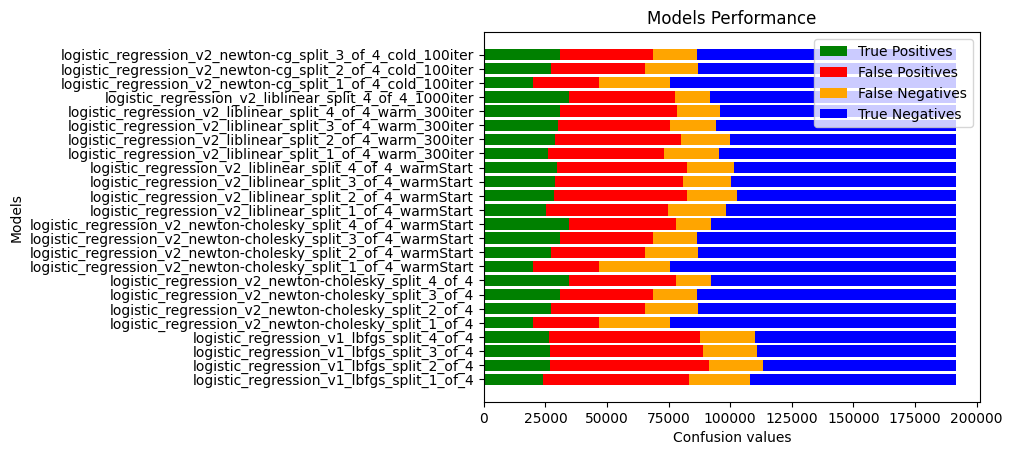

Split 4: 2023-04-30 20:31:24.938213


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 43.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 43.2min finished


logistic_regression_v2_newton-cg_split_4_of_4_cold_100iter: 0.663867385179309


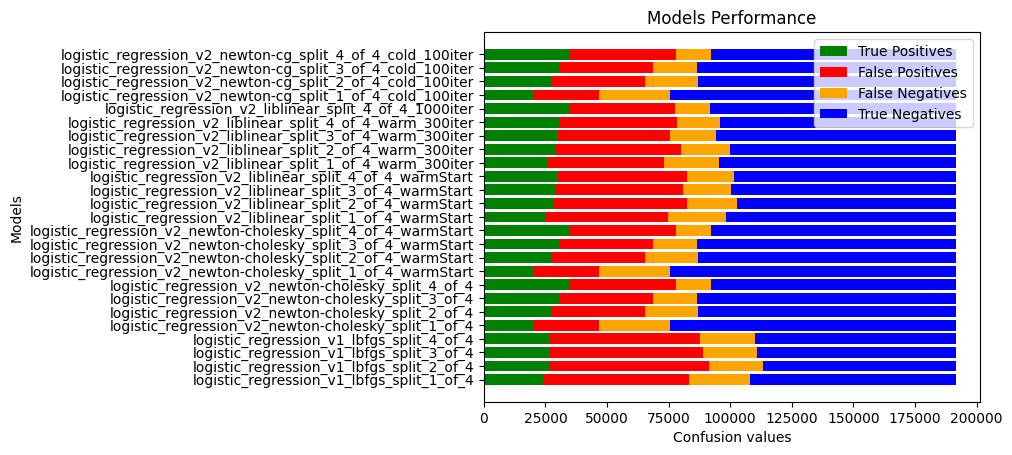

FINISH: 2023-04-30 21:14:39.157578


In [38]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, description="cold_100iter", max_iter=100, random_state=RANDOM_STATE, class_weight="balanced", solver='newton-cg', verbose=4, warm_start=False)


START AT: 2023-04-30 22:04:47.345844
Split 1: 2023-04-30 22:04:53.180343


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 34 seconds
logistic_regression_v2_saga_split_1_of_4_warm_100iter: 0.5916552306555474


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.4s finished


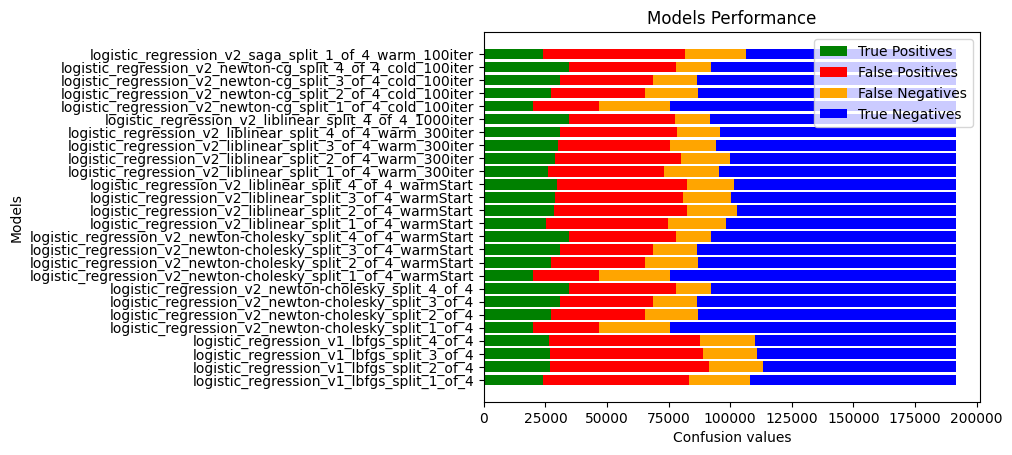

Split 2: 2023-04-30 22:05:29.980718


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 65 seconds
logistic_regression_v2_saga_split_2_of_4_warm_100iter: 0.5429596508607994


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


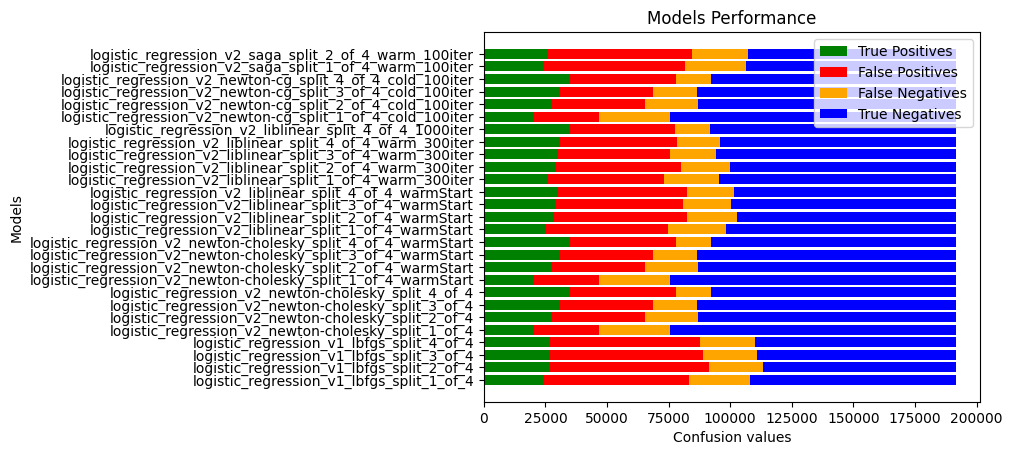

Split 3: 2023-04-30 22:06:37.628209


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 93 seconds
logistic_regression_v2_saga_split_3_of_4_warm_100iter: 0.5978321809007662


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


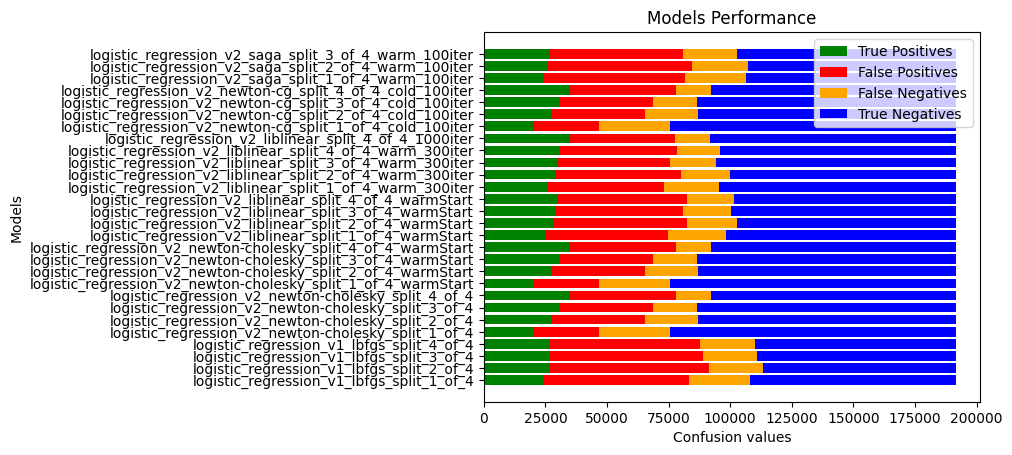

Split 4: 2023-04-30 22:08:13.869163


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [39]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, description="warm_100iter", max_iter=100, random_state=RANDOM_STATE, class_weight="balanced", solver='saga', verbose=4, warm_start=True)


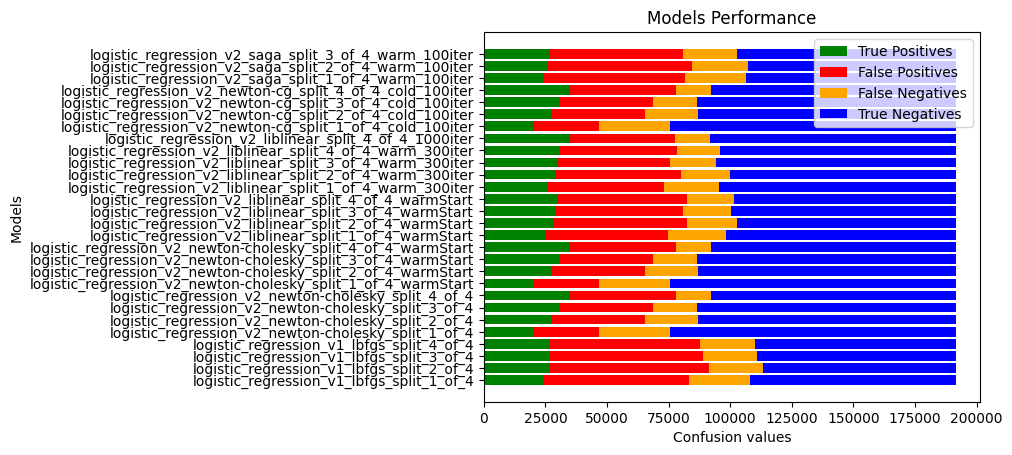

In [40]:
display_confusion_graph()

In [48]:
len(models)

28

START AT: 2023-04-30 22:18:46.764629
Split 4: 2023-04-30 22:18:51.400923


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 683 seconds
logistic_regression_v2_saga_split_4_of_4_cold_500iter: 0.5962469568071779


C:\Users\IvarY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.4min finished


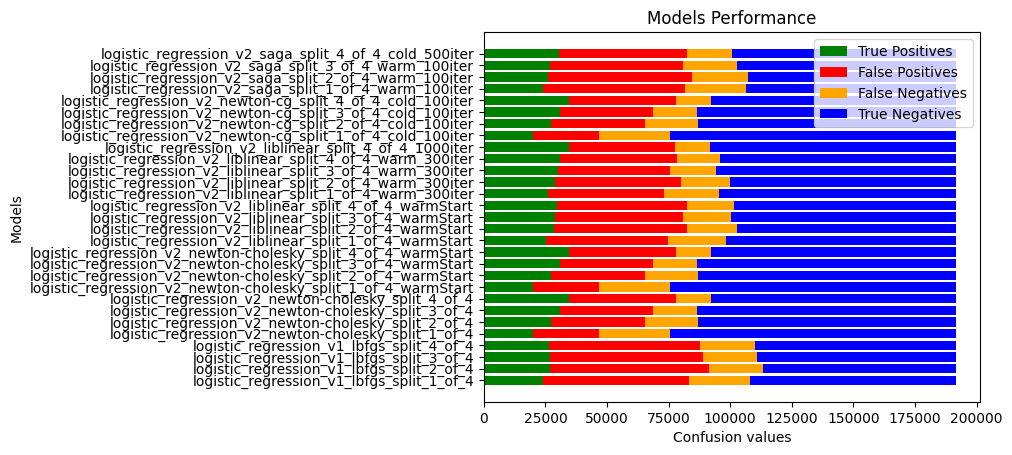

FINISH: 2023-04-30 22:30:18.271455


In [49]:
logistic_regression_custom_cv(X=X, y=y, n_splits=4, min_split=4, description="cold_500iter", max_iter=500, random_state=RANDOM_STATE, class_weight="balanced", solver='saga', verbose=4, warm_start=True)

In [52]:
(true_positive[11]+true_negative[11])/len(y)

0.7004511905693347